In [30]:
import xarray as xr 
xr.set_options(display_style='html')  # make xarray summary look better

import numpy as np
import pandas as pd

# some plotting options you can ignore
import matplotlib.pyplot as plt
import sciplotlib.style as splstyle 
import sciplotlib.polish as splpolish

# housekeeping
import os
import glob

# other utils
import itertools

# Xarray for spike data

Brief description of the data I am dealing with: 

 1. Spikes from multiple neurons from multiple brain areas
 2. Multiple mice and multiple sessions per mice (different neurons in each session)
 3. Audio-visual decision making task, so I also want to keep track of (1) decision / movement time (2) audio stimulus (3) visual stimulus (4) Trial number
    
    

## For storage

Xarray is okay for storing binned spike data. 

Example: 

 - I have a folder of `.nc` files containing the spike rate aligned to stimulus onset (50 time bins from -0.7 to 0.7 seconds peri-movement)


In [14]:
aligned_spike_rate_file_path = '/media/timsit/Partition 1/data/interim/active-subset-single-condition-alignment-50-time-bin-w-timeout-2020-02-16/subject_3_exp_21_MOs_aligned_to_stimOnTime.nc'
aligned_spike_rate_ds = xr.open_dataset(aligned_spike_rate_file_path)

In [15]:
aligned_spike_rate_ds

<xarray.Dataset>
Dimensions:        (Cell: 166, Exp: 1, Time: 50, Trial: 842)
Coordinates:
    PeriEventTime  (Time) float64 ...
    CellLoc        (Cell) object ...
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * Trial          (Trial) int64 0 1 2 3 4 5 6 7 ... 835 836 837 838 839 840 841
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * Exp            (Exp) int64 21
Data variables:
    firing_rate    (Cell, Time, Trial, Exp) float64 ...
    audDiff        (Trial, Exp) float64 ...
    visDiff        (Trial, Exp) float64 ...
    responseMade   (Trial, Exp) int64 ...
Attributes:
    bin_width:     0.027999999999999997
    num_time_bin:  50

Variables: 

 - `firing_rate`: firing rate of each neuron over time 
 - `audDiff`: direction of the audio stimulus (-60: left, 60: right, np.inf: no audio)
 - `visDiff`: direction and contrast of visual stimulus (-0.8: contrast of 0.8 on the left)
 - `responseMade`: choice of the animal each trial (1: left, 2:right or 0:timeout)

Ideally these information can be stored in attributes of the Xarray dataset

**Concept: Dimensions and coordinates**

**Shared dimensions makes it easy to subset data**

Let's say I want to plot the firing rate of neuron 82 when the audio stimulus is on the right and the visual is on the left, and compare the firing rate when the response is to the left and the repsonse is to the right

In [17]:
respond_left_ds = aligned_spike_rate_ds.where(
    (aligned_spike_rate_ds['Cell'] == 82) &
    (aligned_spike_rate_ds['audDiff'] == 60) & 
    (aligned_spike_rate_ds['visDiff'] < 0) &
    (aligned_spike_rate_ds['responseMade'] == 1),
    drop=True
)

In [18]:
respond_left_ds

<xarray.Dataset>
Dimensions:        (Cell: 1, Exp: 1, Time: 50, Trial: 27)
Coordinates:
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
    CellLoc        (Cell) object 'MOs'
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * Trial          (Trial) int64 12 20 42 67 97 135 ... 727 743 752 780 781 792
  * Cell           (Cell) int64 82
  * Exp            (Exp) int64 21
Data variables:
    firing_rate    (Cell, Time, Trial, Exp) float64 0.0 0.0 0.0 ... 0.0 35.71
    audDiff        (Trial, Exp, Cell) float64 60.0 60.0 60.0 ... 60.0 60.0 60.0
    visDiff        (Trial, Exp, Cell) float64 -0.4 -0.8 -0.2 ... -0.2 -0.8 -0.8
    responseMade   (Trial, Exp, Cell) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes:
    bin_width:     0.027999999999999997
    num_time_bin:  50

Let's say we then want to plot the mean activity across all trials

In [22]:
respond_left_ds_mean_activity = respond_left_ds.mean(dim='Trial')

In [33]:
# We can also compute the standard deviation across trials
respond_left_ds_std_activity = respond_left_ds.std(dim='Trial')

In [23]:
respond_left_ds_mean_activity

<xarray.Dataset>
Dimensions:        (Cell: 1, Exp: 1, Time: 50)
Coordinates:
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
    CellLoc        (Cell) object 'MOs'
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * Cell           (Cell) int64 82
  * Exp            (Exp) int64 21
Data variables:
    firing_rate    (Cell, Time, Exp) float64 5.291 2.646 3.968 ... 9.259 3.968
    audDiff        (Exp, Cell) float64 60.0
    visDiff        (Exp, Cell) float64 -0.463
    responseMade   (Exp, Cell) float64 1.0

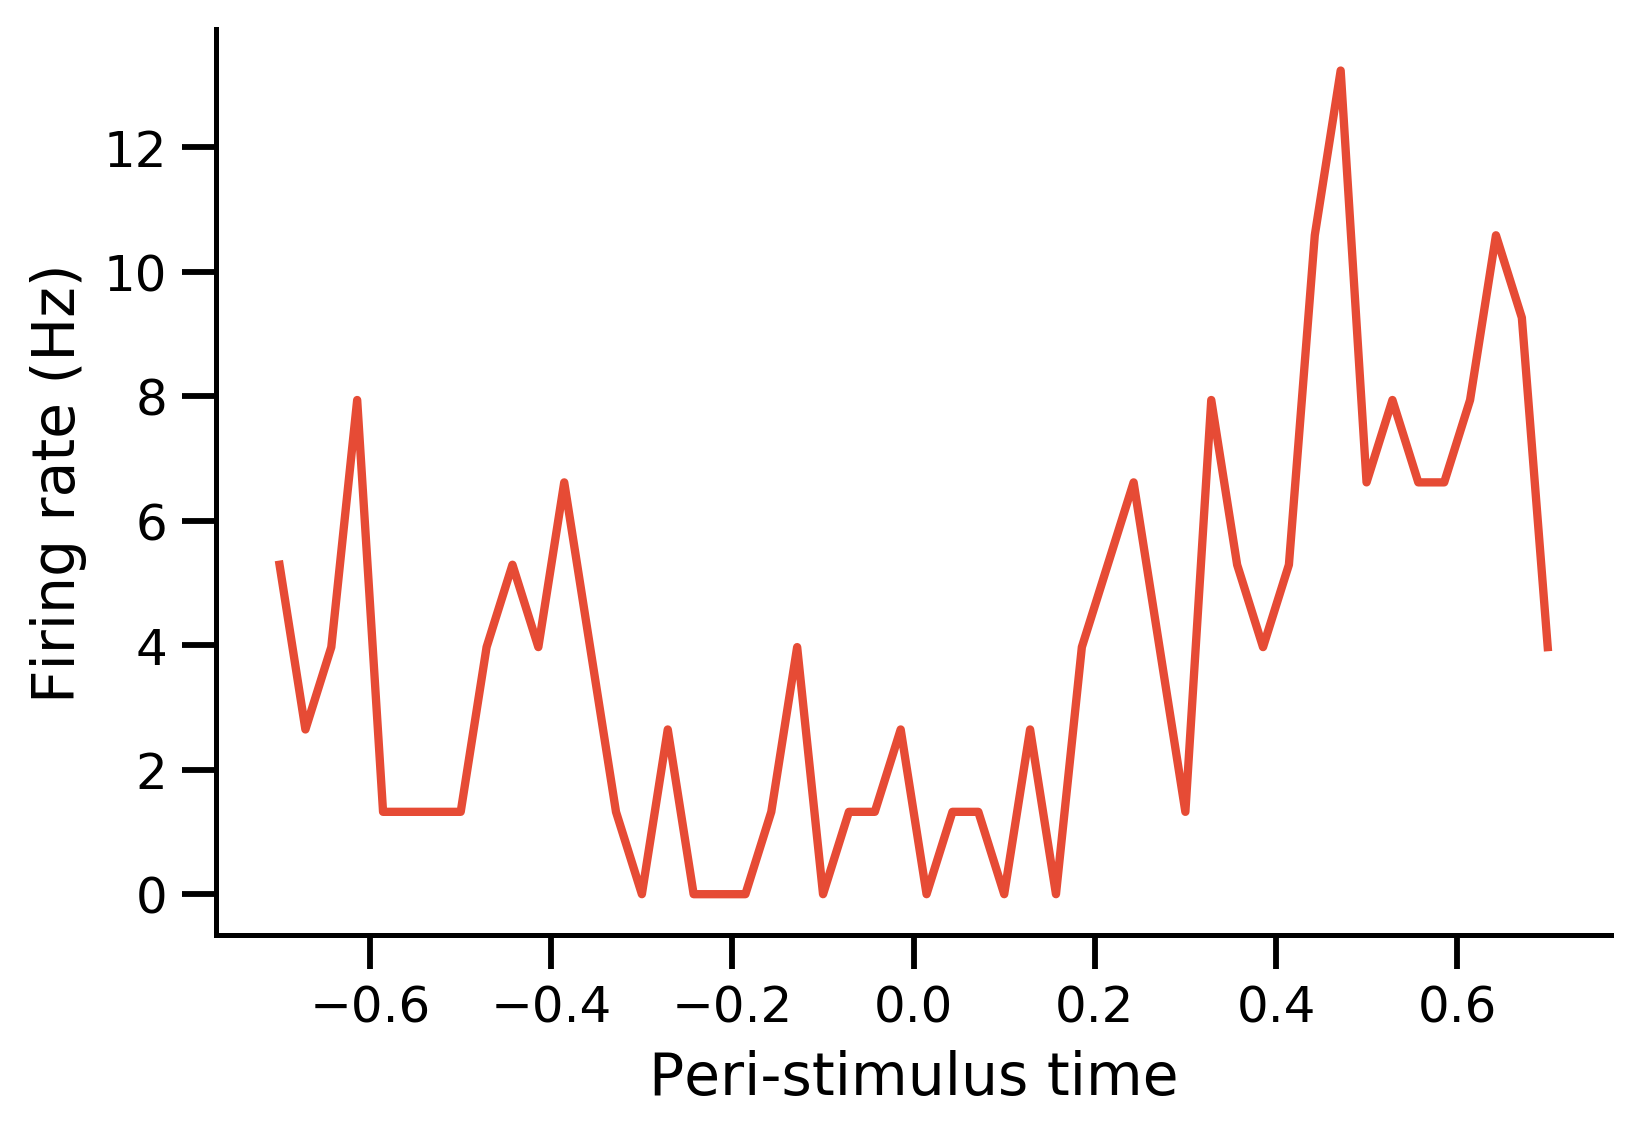

In [37]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)
    
    mean_activity = np.squeeze(respond_left_ds_mean_activity['firing_rate'])
    
    ax.plot(respond_left_ds_mean_activity['PeriEventTime'], 
           mean_activity)
    
    # optional: shade the standard deviation as well 
    # std_activity = np.squeeze(respond_left_ds_std_activity['firing_rate'])
    # ax.fill_between(respond_left_ds_mean_activity['PeriEventTime'], 
    #                mean_activity - std_activity, mean_activity + std_activity, alpha=0.3)

    ax.set_xlabel('Peri-stimulus time')
    ax.set_ylabel('Firing rate (Hz)')



## Should I store everything in one big array, and separate them into different files?

Depends on which part of the data you usually access, eg. I usually only care about MOs neurons and my analysis are usually done on a per-experiment level (since different neurons are recorded for each experiment), so each `.nc`file for me is from one subject, one experiment, and one brain region.

In [10]:
alignment_folder = '/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/'

In [16]:
print('\n'.join(glob.glob(os.path.join(alignment_folder, '*'))[0:10]))

/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_3_exp_28_ACAd_aligned_to_firstMoveTimes.nc
/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_3_exp_24_OLF_aligned_to_firstMoveTimes.nc
/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_4_exp_36_MOs_aligned_to_firstMoveTimes.nc
/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_4_exp_35_MOs_aligned_to_firstMoveTimes.nc
/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_6_exp_52_PL_aligned_to_firstMoveTimes.nc
/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_1_exp_8_STRv_aligned_to_firstMoveTimes.nc
/media/timsit/Partition 1/data/interim/active-alignment-two-movement-min-reaction-time-150/subject_5_exp_45_TT_aligned_to_firstMoveTimes.nc
/media/timsit/

Xarry provides a very nice way to load and combine multiple files, for example, if I want everything from subject 3, then I simply do the following. (This is also where lazy loading and dask parallelisation helps)

In [20]:
combined_ds = xr.open_mfdataset(os.path.join(alignment_folder, 'subject_3*'), parallel=True,
                               combine='by_coords')

In [21]:
combined_ds

<xarray.Dataset>
Dimensions:        (Cell: 252, Exp: 11, Time: 50, Trial: 820)
Coordinates:
    CellLoc        (Exp, Cell) object 'PL' 'PL' 'PL' 'PL' ... nan nan nan nan
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
  * Exp            (Exp) int64 21 22 23 24 25 26 27 28 29 30 31
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 245 246 247 248 249 250 251
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * Trial          (Trial) int64 0 1 2 3 4 5 6 7 ... 813 814 815 816 817 818 819
Data variables:
    firing_rate    (Cell, Time, Trial, Exp) float64 dask.array<chunksize=(252, 50, 820, 1), meta=np.ndarray>
    audDiff        (Cell, Trial, Exp) float64 dask.array<chunksize=(252, 820, 1), meta=np.ndarray>
    visDiff        (Cell, Trial, Exp) float64 dask.array<chunksize=(252, 820, 1), meta=np.ndarray>
    responseMade   (Cell, Trial, Exp) float64 dask.array<chunksize=(252, 820, 1), meta=np.ndarray>
Attributes:
    bin_width:     0.027999999999999997
    num_time_bin:  50

If I want cells from the MOs across all subjects and experiments, then I do

In [25]:
MOs_cell_ds = xr.open_mfdataset(os.path.join(alignment_folder, 'subject_*_exp_*_MOs*'), parallel=True,
                               combine='by_coords')

In [26]:
MOs_cell_ds

,Array,Chunk
Bytes,3.54 GB,69.46 MB
Shape,"(196, 50, 886, 51)","(196, 50, 886, 1)"
Count,639 Tasks,51 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,70.85 MB,1.39 MB
Shape,"(196, 886, 51)","(196, 886, 1)"
Count,645 Tasks,51 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


### Xarray is not good for storing sparse data, but you can still wrap around it

Additional notes: 

 - storing sparse matrices in a way that works well with xarray is also slightly messy, mainly because Xarray only wraps around sparse xarray from the python package `sparse`, and not with `scipy.sparse` objects 
 - but most saving options, such as `npz` and `h5sparse` (for storing sparse arrays in hdf5) only support `scipy.sparse` objects
 - overall, there will be quite a lot of conversion between the two
 - there may be better options, such as PyTables, I haven't used sparse arrays much

In [69]:
import h5sparse
import sparse
sparse_spike_matrix_file_path = '/home/timsit/xarray-intro/data/sparse_spikes.h5'
sparse_spike_file = h5sparse.File(sparse_spike_matrix_file_path, 'r')

In [84]:
sparse_spike_file['Spike/data']

<HDF5 group "/Spike/data" (3 members)>

In [73]:
sparse_spike_matrix_sp = sparse_spike_file['Spike/data'][:]

In [76]:
np.shape(sparse_spike_matrix_sp)

(415, 7990000)

In [77]:
sparse_spike_matrix = sparse.COO.from_scipy_sparse(sparse_spike_matrix_sp)

Ideally you will also have the dimension names and coordinate values in the hdf5 file, but for now, let's assume we already know the matrix has dimensions Cell and Time.

In [78]:
spike_ds = xr.Dataset(
    {'Spike': (['Cell', 'Time'], sparse_spike_matrix[:])},
    coords={'Cell': ('Cell', sparse_spike_file['Spike/Cell/Cell'][:]),
           'Bin': ('Time', sparse_spike_file['Spike/Time/Bin'][:]),
           'Time': ('Time', sparse_spike_file['Spike/Time/Time'][:])}
)

In [80]:
spike_ds

Format,coo
Data Type,int64
Shape,"(415, 7990000)"
nnz,4094208
Density,0.0012347386039778638
Read-only,True
Size,93.7M
Storage ratio,0.0


Most of xarray's features will still work

In [92]:
spike_count_per_cell = spike_ds.sum('Time')

In [93]:
spike_count_per_cell

Format,coo
Data Type,int64
Shape,"(415,)"
nnz,415
Density,1.0
Read-only,True
Size,6.5K
Storage ratio,2.0


## For computation

### Organising Xarrays for tensor decomposition

Use case, I want to apply some dimensionality reduction method for data arrays with more than 2 dimensions (eg. PCA generalised to tensors): 

 1. demixed principal component analysis
 2. Tensor Component Analysis

In [6]:
# some custom analysis code 
import src.data.process_ephys_data as pephys

query_subject = 3 
query_exp = 21
alignment_folder = '/media/timsit/Partition 1/data/interim/active-subset-single-condition-alignment-50-time-bin-2020-02-11/'
target_brain_region = 'MOs'
alignment_ds = pephys.load_subject_exp_alignment_ds(
                           alignment_folder,
                          str(query_subject), str(query_exp), 
                          target_brain_region=target_brain_region,
                          aligned_event='movementTimes',
                          alignment_file_ext='.nc')

In [7]:
alignment_ds

<xarray.Dataset>
Dimensions:        (Cell: 166, Time: 50, Trial: 820)
Coordinates:
    PeriEventTime  (Time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
  * Trial          (Trial) int64 0 1 2 3 4 5 6 7 ... 813 814 815 816 817 818 819
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    Exp            int64 21
    CellLoc        (Cell) object dask.array<chunksize=(166,), meta=np.ndarray>
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
Data variables:
    firing_rate    (Cell, Time, Trial) float64 dask.array<chunksize=(166, 50, 820), meta=np.ndarray>
    audDiff        (Cell, Trial) float64 dask.array<chunksize=(166, 820), meta=np.ndarray>
    visDiff        (Cell, Trial) float64 dask.array<chunksize=(166, 820), meta=np.ndarray>
    responseMade   (Cell, Trial) float64 dask.array<chunksize=(166, 820), meta=np.ndarray>
Attributes:
    bin_width:     0.027999999999999997
    num_time_bin:  50

Goal: I want to coerce the following data into an array with the dimensions (to do tensor component analysis): 
        
(Cell, Time, Trial, Audio, Visual, Response)

In [14]:
# a rather brute approach: we subset datasets and put them into a list

aud_levels = [-60, 60, 0] 

vis_levels = [[-0.8, -0.4, -0.2, 0.1], 0.0, [0.1, 0.2, 0.4, 0.8]]
stim_levels = itertools.product(aud_levels, vis_levels)
response_levels = [1, 2]

condition_levels = itertools.product(stim_levels, response_levels)

aud_cond_dict = {-60: 'left', 60: 'right', 0: 'center'}
response_cond_dict = {1: 'left', 2: 'right'}


trial_ds_list = list()
for s_level, r_level in condition_levels: 
    condition_subset_alignment_ds = alignment_ds.where(
    (alignment_ds['audDiff'] == s_level[0]) & 
    (alignment_ds['visDiff'].isin(s_level[1])) &
    (alignment_ds['responseMade'] == r_level), 
    drop=True
    )
    
    if type(s_level[1]) is not list:
        vis_cond = 'center'
    elif s_level[1][0] < 0:
        vis_cond = 'left'
    elif s_level[1][0] > 0:
        vis_cond = 'right'
    
    aud_cond = aud_cond_dict[s_level[0]]
    response_cond = response_cond_dict[r_level]
    
    # trial_mean_activity_ds = condition_subset_alignment_ds.mean('Trial')
    
    n_dim_to_expand = 3
    firing_rate = condition_subset_alignment_ds['firing_rate'].values
    
    trial_ds = xr.Dataset(
    {'firing_rate': (['Cell', 'Time', 'Trial', 'audCond', 'visCond', 'responseMade'],
                    firing_rate.reshape(firing_rate.shape + (1, ) * n_dim_to_expand)
                    )},
    coords={'Cell': condition_subset_alignment_ds['Cell'], 
           'Time': condition_subset_alignment_ds['Time'],
           'audCond': [aud_cond], 
           'visCond': [vis_cond],
           'responseMade': [response_cond],
           'Trial': np.arange(len(condition_subset_alignment_ds['Trial'])) # not here we re-index trials
           }
    )
    
    trial_ds_list.append(trial_ds)

We have created a list of xarray datasets where each element is a dataset of a specific auditory, visual and response condition. Note that we can use strings (and of course numbers) as coordinate values.

In [15]:
trial_ds_list[0]

<xarray.Dataset>
Dimensions:        (Cell: 166, Time: 50, Trial: 52, audCond: 1, responseMade: 1, visCond: 1)
Coordinates:
    Exp            int64 21
    CellLoc        (Cell) object dask.array<chunksize=(166,), meta=np.ndarray>
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
    PeriEventTime  (Time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * audCond        (audCond) <U4 'left'
  * visCond        (visCond) <U4 'left'
  * responseMade   (responseMade) <U4 'left'
  * Trial          (Trial) int64 0 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50 51
Data variables:
    firing_rate    (Cell, Time, Trial, audCond, visCond, responseMade) float64 0.0 ... 0.0

Xarray comes with a clever function `combine_by_coords` that automatically combine datasets along multiple dimensions.

Additional details: 

 - for concatenating along one dimension, use `xr.concat()`
 - for more control of combining along multiple dimension, use `xr.combine_nested`

In [18]:
all_trial_cond_ds = xr.combine_by_coords(trial_ds_list)

In [19]:
all_trial_cond_ds

<xarray.Dataset>
Dimensions:        (Cell: 166, Time: 50, Trial: 113, audCond: 3, responseMade: 2, visCond: 3)
Coordinates:
    CellLoc        (Cell) object 'MOs' 'MOs' 'MOs' 'MOs' ... 'MOs' 'MOs' 'MOs'
    Exp            int64 21
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
  * Trial          (Trial) int64 0 1 2 3 4 5 6 7 ... 106 107 108 109 110 111 112
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * responseMade   (responseMade) object 'left' 'right'
  * audCond        (audCond) object 'center' 'left' 'right'
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * visCond        (visCond) object 'center' 'left' 'right'
Data variables:
    firing_rate    (Cell, Time, Trial, audCond, visCond, responseMade) float64 0.0 ... nan

We note the following things: 
    
 1. Not all auditory-visual conditions has the same number of trials, in this case, xarray imputes them with np.nan, you can optionally specify a custom fill value for missing data 
 2. Xarray does not currently have support for doing (1) in a sparse manner

dPCA actually wants the input to be the activity averaged across all trials (for each stimulus condition, time and cell), this is easily done in xarray

In [20]:
all_trial_cond_ds_mean = all_trial_cond_ds.mean('Trial')

In [21]:
all_trial_cond_ds_mean

<xarray.Dataset>
Dimensions:        (Cell: 166, Time: 50, audCond: 3, responseMade: 2, visCond: 3)
Coordinates:
    CellLoc        (Cell) object 'MOs' 'MOs' 'MOs' 'MOs' ... 'MOs' 'MOs' 'MOs'
    Exp            int64 21
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * responseMade   (responseMade) object 'left' 'right'
  * audCond        (audCond) object 'center' 'left' 'right'
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * visCond        (visCond) object 'center' 'left' 'right'
Data variables:
    firing_rate    (Cell, Time, audCond, visCond, responseMade) float64 0.0 ... 0.0

And let's say rather than having a separate dimension for auditory and visual condition, we want just a single stimulus dimension to do the decomposition

In [24]:
all_trial_cond_ds_mean_stacked = all_trial_cond_ds_mean.stack({'stimCond': ['audCond', 'visCond']})

In [26]:
all_trial_cond_ds_mean_stacked

<xarray.Dataset>
Dimensions:        (Cell: 166, Time: 50, responseMade: 2, stimCond: 9)
Coordinates:
    CellLoc        (Cell) object 'MOs' 'MOs' 'MOs' 'MOs' ... 'MOs' 'MOs' 'MOs'
    Exp            int64 21
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * responseMade   (responseMade) object 'left' 'right'
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * stimCond       (stimCond) MultiIndex
  - audCond        (stimCond) object 'center' 'center' ... 'right' 'right'
  - visCond        (stimCond) object 'center' 'left' 'right' ... 'left' 'right'
Data variables:
    firing_rate    (Cell, Time, responseMade, stimCond) float64 0.0 0.0 ... 0.0

The dPCA function actually wants us to have Time as the first dimension. The current order of dimensions for `firing_rate` is (Cell, Time, responseMade, stimCond), we can use xarray's transpose function to deal with that:

In [28]:
all_trial_cond_ds_reshaped = all_trial_cond_ds_mean_stacked.transpose('Time', 'Cell', 'stimCond', 'responseMade')

In [31]:
all_trial_cond_ds_reshaped

<xarray.Dataset>
Dimensions:        (Cell: 166, Time: 50, responseMade: 2, stimCond: 9)
Coordinates:
    CellLoc        (Cell) object 'MOs' 'MOs' 'MOs' 'MOs' ... 'MOs' 'MOs' 'MOs'
    Exp            int64 21
    PeriEventTime  (Time) float64 -0.7 -0.6714 -0.6429 ... 0.6429 0.6714 0.7
  * Cell           (Cell) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * responseMade   (responseMade) object 'left' 'right'
  * Time           (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * stimCond       (stimCond) MultiIndex
  - audCond        (stimCond) object 'center' 'center' ... 'right' 'right'
  - visCond        (stimCond) object 'center' 'left' 'right' ... 'left' 'right'
Data variables:
    firing_rate    (Time, Cell, stimCond, responseMade) float64 0.0 0.0 ... 0.0

We can then easily convert this back to a numpy array to be inputted to some function

In [33]:
neural_data_numpy = all_trial_cond_ds_reshaped['firing_rate'].values 
print(type(neural_data_numpy))
print(np.shape(neural_data_numpy))

<class 'numpy.ndarray'>
(50, 166, 9, 2)


# Xarray for 2-photon data

## From suite2p output to xarray datasets

## 3 datasetes: Neural data, behaviour data, and experiment data

In [33]:
interval_experiment_folder = '/media/timsit/Partition 1/2p-processed/TS004/2019-12-18/1/'

block_ds = xr.open_dataset(os.path.join(
interval_experiment_folder, 'block_xarray.nc'
))

interval_plane_activity_path_list = glob.glob(os.path.join(
interval_experiment_folder, '2p/suite2p/plane*.nc'))
twop_ds = [xr.open_dataset(fname) for fname in interval_plane_activity_path_list]


timeline_ds =  xr.open_dataset(os.path.join(
interval_experiment_folder, 'timeline.nc'
))


In [47]:
timeline_ds

<xarray.Dataset>
Dimensions:       (Time: 8282000)
Coordinates:
  * Time          (Time) float64 0.0 0.001 0.002 ... 8.282e+03 8.282e+03
Data variables:
    photoDiode    (Time) float64 ...
    audioMonitor  (Time) float64 ...
Attributes:
    subject_name:  TS004
    exp_date:      2019-12-18
    exp_number:    1

In [48]:
block_ds

<xarray.Dataset>
Dimensions:             (Trial: 1016)
Coordinates:
  * Trial               (Trial) int64 0 1 2 3 4 5 ... 1011 1012 1013 1014 1015
Data variables:
    newTrialValues      (Trial) uint8 ...
    newTrialTimes       (Trial) float64 ...
    repeatNumValues     (Trial) uint8 ...
    repeatNumTimes      (Trial) float64 ...
    trialNumValues      (Trial) uint16 ...
    trialNumTimes       (Trial) float64 ...
    name                (Trial) object ...
    folder              (Trial) object ...
    currMoviePathTimes  (Trial) float64 ...
    playMoviePathTimes  (Trial) float64 ...
    playingMovieValues  (Trial) uint8 ...
    playingMovieTimes   (Trial) float64 ...
    t_intValues         (Trial) float64 ...
    t_intTimes          (Trial) float64 ...
    movieIdxValues      (Trial) uint16 ...
    movieIdxTimes       (Trial) float64 ...
    endTrialValues      (Trial) uint8 ...
    endTrialTimes       (Trial) float64 ...
Attributes:
    expDef:                 \\zserver.cortexlab.net\Code\Rigging\ExpDefinitio...
    rigName:                zurprise
    startDateTime:          737777.7489224421
    startDateTimeStr:       18-Dec-2019 17:58:26
    endStatus:              quit
    expRef:                 2019-12-18_1_TS004
    experimentInitTime:     3.6784023022046313
    experimentStartedTime:  42.290851651574485
    experimentEndedTime:    8234.959741806262
    experimentCleanupTime:  8241.022862436832
    endDateTime:            737777.844426875
    endDateTimeStr:         18-Dec-2019 20:15:58
    duration:               8251.582999999999

In [50]:
twop_ds[0]

<xarray.Dataset>
Dimensions:       (Cell: 667, Plane: 1, Time: 20570)
Coordinates:
  * Plane         (Plane) int64 4
  * Cell          (Cell) int64 0 1 2 3 4 5 6 7 ... 660 661 662 663 664 665 666
  * Time          (Time) float64 10.01 10.41 10.81 ... 8.242e+03 8.243e+03
Data variables:
    Flourescence  (Plane, Cell, Time) float32 ...
    Spikes        (Plane, Cell, Time) float32 ...
    X_loc         (Cell) float64 ...
    Y_loc         (Cell) float64 ...
Attributes:
    meanImg:  [861.38357895 797.02816876 802.54649541 ... 704.97635338 658.26...

### Simplified alignment demo

In [37]:
time_before_event = 1
time_after_event = 2.5
event_time = np.array([0, 10, 20, 30])

event_bins = list(zip(event_time - time_before_event,
                      event_time + time_after_event))

event_interval_bins = pd.IntervalIndex.from_tuples(event_bins, closed='both')
aligned_xarray_tuple = twop_ds[0].groupby_bins('Time', event_interval_bins)
aligned_xarray_list = [i[1] for i in list(aligned_xarray_tuple)]
aligned_ds = xr.concat(aligned_xarray_list, dim='Trial')

In [38]:
aligned_ds

<xarray.Dataset>
Dimensions:       (Cell: 667, Plane: 1, Time: 25, Trial: 3)
Coordinates:
  * Plane         (Plane) int64 4
  * Cell          (Cell) int64 0 1 2 3 4 5 6 7 ... 660 661 662 663 664 665 666
  * Time          (Time) float64 10.01 10.41 10.81 11.21 ... 31.61 32.01 32.41
Dimensions without coordinates: Trial
Data variables:
    Flourescence  (Trial, Plane, Cell, Time) float32 4417.1655 ... 2587.0579
    Spikes        (Trial, Plane, Cell, Time) float32 0.0 269.56982 ... 0.0 0.0
    X_loc         (Trial, Cell, Time) float64 388.0 388.0 388.0 ... 486.0 486.0
    Y_loc         (Trial, Cell, Time) float64 378.0 378.0 378.0 ... 440.0 440.0
Attributes:
    meanImg:  [861.38357895 797.02816876 802.54649541 ... 704.97635338 658.26...

### Pre-made alignment dataset

In [44]:
alignment_folder = '/media/timsit/Partition 1/2p-processed/TS004/2019-12-18/1/2p/suite2p/alignment/'
fname_list = glob.glob(os.path.join(alignment_folder, '*.nc'))
# interval_av_aligned_activity = [xr.open_dataset(fname) for fname in fname_list]
interval_av_aligned_activity_all_planes = xr.open_mfdataset(fname_list, combine='by_coords', parallel=True)

In [45]:
interval_av_aligned_activity_all_planes

,Array,Chunk
Bytes,4.31 GB,359.01 MB
Shape,"(667, 29, 29, 12, 10, 8)","(667, 29, 29, 1, 10, 8)"
Count,150 Tasks,12 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,4.31 GB,359.01 MB
Shape,"(667, 29, 29, 12, 10, 8)","(667, 29, 29, 1, 10, 8)"
Count,150 Tasks,12 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Let's say I want the mean activity of each audio-video pair for cells in the 4th plane in trial 1 in cell 10

In [68]:
subset_activity = interval_av_aligned_activity_all_planes.sel(
Plane=3, Trial=1, Cell=10).mean('FrameIndex')

In [49]:
subset_activity

<xarray.Dataset>
Dimensions:        (audio: 29, video: 29)
Coordinates:
    Trial          int64 1
  * video          (video) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0
  * audio          (audio) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0
    Cell           int64 10
    Plane          int64 3
Data variables:
    imageTime      (audio, video) float64 dask.array<chunksize=(29, 29), meta=np.ndarray>
    PeriEventTime  (audio, video) float64 dask.array<chunksize=(29, 29), meta=np.ndarray>
    Spikes         (audio, video) float32 dask.array<chunksize=(29, 29), meta=np.ndarray>
    Flourescence   (audio, video) float32 dask.array<chunksize=(29, 29), meta=np.ndarray>

Note that the operations are applied across all datavariables, and so we get the mean Spikes and Fluorescence 

/home/timsit/.conda/envs/msi/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/timsit/.conda/envs/msi/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


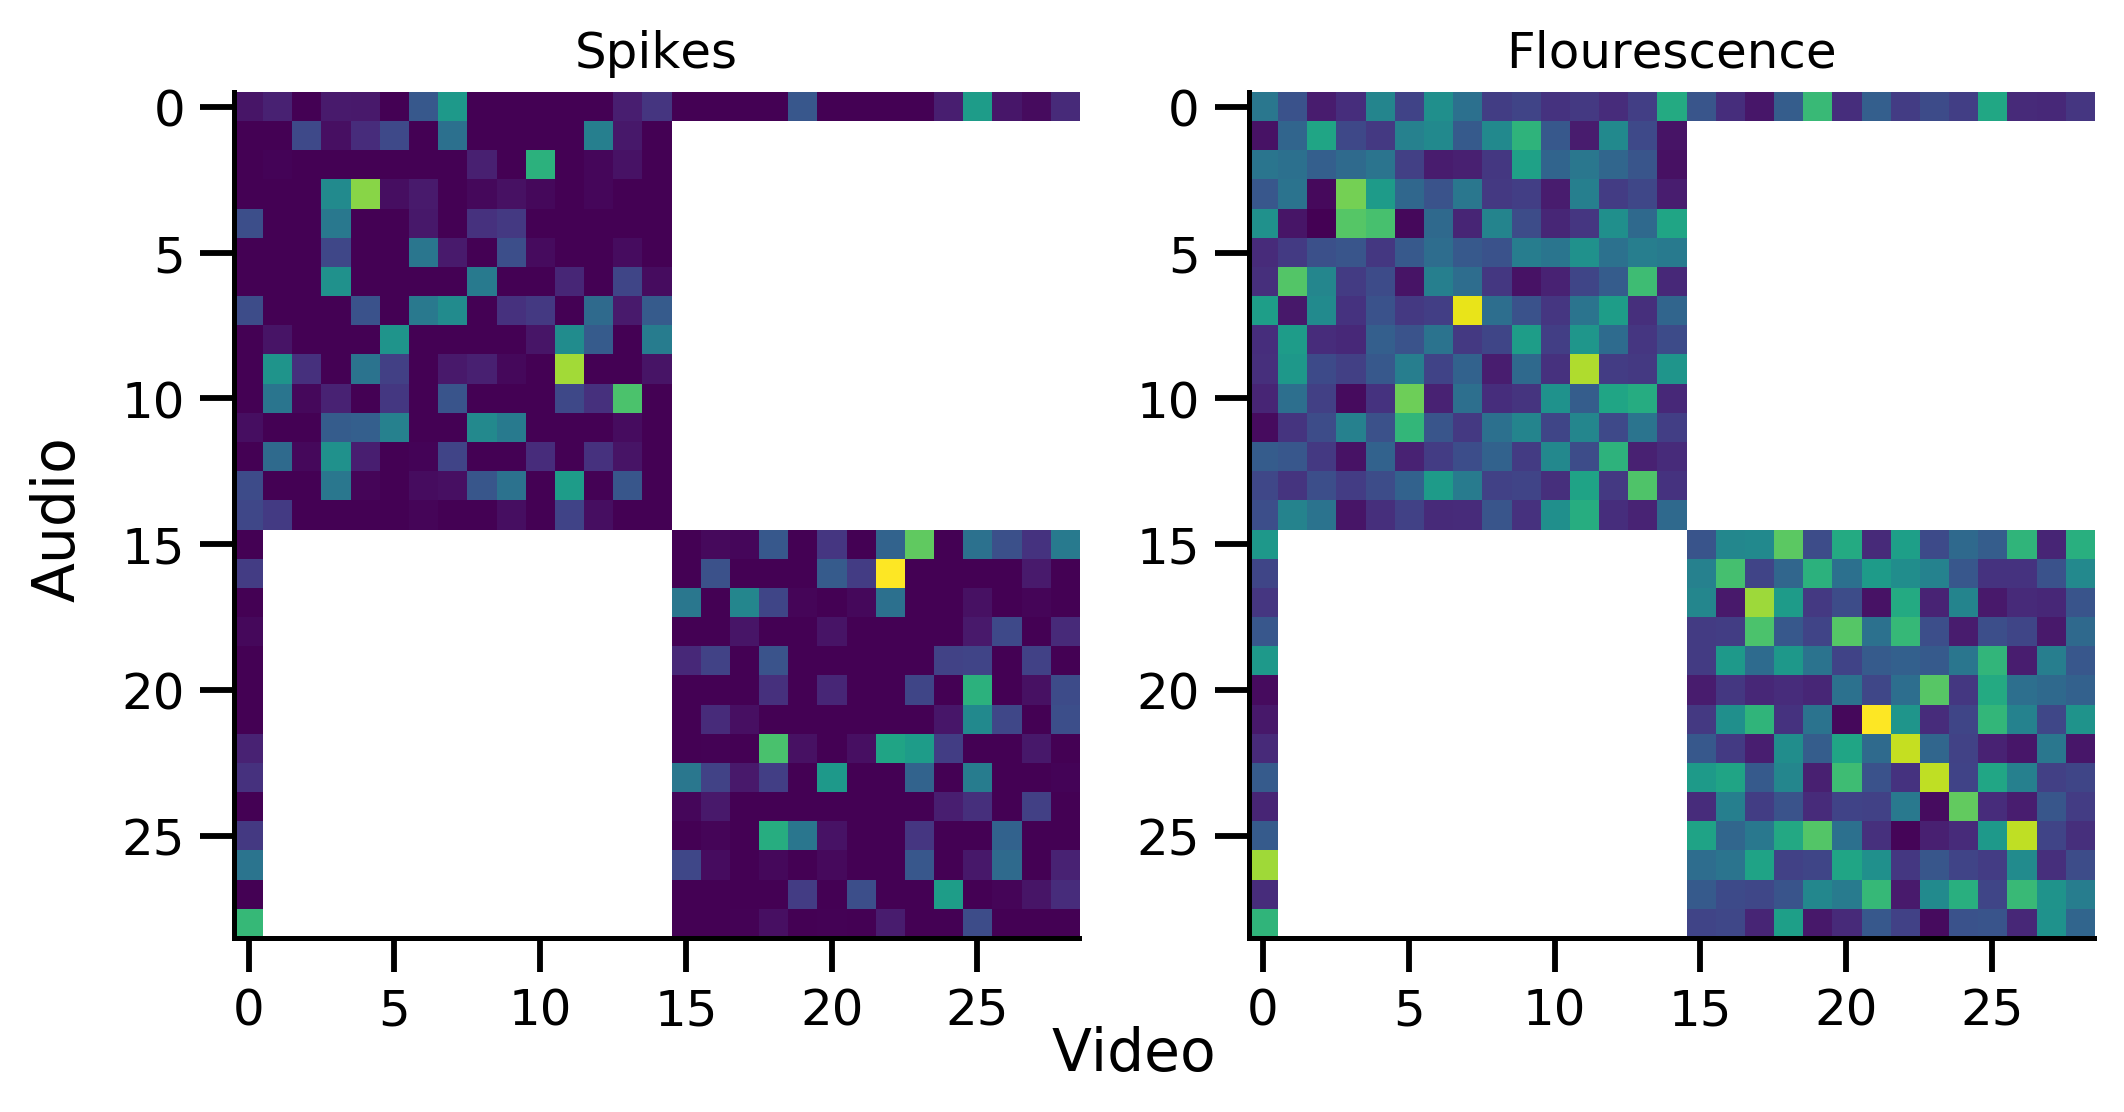

In [69]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    axs[0].set_title('Spikes', size=12)
    axs[0].imshow(subset_activity['Spikes'])
    
    axs[1].set_title('Flourescence', size=12)
    axs[1].imshow(subset_activity['Flourescence'])
    
    fig.text(0.5, 0.04, 'Video', size=14, ha='center')
    fig.text(0.04, 0.5, 'Audio', size=14, va='center', rotation=90)